<a href="https://colab.research.google.com/github/sbmoyano/data_science_projects/blob/master/fraud_detection/fraud_detection_classification_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Through this notebook I will perfrom feature engineering creating new features from the ones in the original dataset. I will use Sklearn's Custom Transformers and Pipeline.

# Set environment

In [ ]:
# Manage paths
import sys

# Data manipulation
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
import matplotlib.pyplot as plt

# feature engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from geopy import distance

# custom transformers
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

# Import data from Google Drive

I will import the datasets, drop unnecessary columns and transform "trans_date_trans_time" column from object to datetime for further use.

In [ ]:
# connect to GoogleDrive on Colab to import stored data there
from google.colab import drive

drive.mount('/content/drive')

# set out root path in Google Drive
%cd /content/drive/My\ Drive/GITHUB/data_science_projects/fraud_detection/

Mounted at /content/drive
/content/drive/My Drive/GITHUB/data_science_projects/fraud_detection


In [ ]:
# path for Colab
sys.path.append("drive/MyDrive/GITHUB/data_science_projects/fraud_detection/")

# path to import pandas and Numpy files
root_path_gd = os.getcwd()
data_path_gd = os.path.join(root_path_gd, ".data/.processed/")

In [ ]:
def import_data(environment="jupyter"):
  
  """
  Import data on a Jupyter notebook or on Google Colab.

  Input:
    environment (str): Either 'jupyter' or 'colab'. If other string is introduced
                       it will raise an exception.
  
  Output:
    preprocessed data: it will include pandas DataFrames and Numpy arrays. It
                       will return X_train, X_val, X_test, y_train, y_val and
                       y_test as Numpy arrays. Moreover, it will return df_train,
                       df_val and df_test as pandas DataFrames. The latter will
                       be used when preparing data for the LSTM model.
  """

  if environment == "jupyter":
    # import on Jupyter Notebook

    df_train = pd.read_csv(os.path.join(os.getcwd(), ".processed/df_train.csv"), 
                           index_col=0)
    df_test = pd.read_csv(os.path.join(os.getcwd(), ".processed/df_test.csv"), 
                          index_col=0)
    df_val = pd.read_csv(os.path.join(os.getcwd(), ".processed/df_val.csv"), 
                         index_col=0)

  elif environment == "colab":
    # import on Google Colab
    df_train = pd.read_csv(os.path.join(data_path_gd, "df_train.csv"), 
                           index_col=0)
    df_test = pd.read_csv(os.path.join(data_path_gd, "df_test.csv"), 
                          index_col=0)
    df_val = pd.read_csv(os.path.join(data_path_gd, "df_val.csv"), 
                         index_col=0)

  else:
    raise Exception("Environment not supported. Try 'jupyter' or 'colab'")

  return df_train, df_test, df_val

In [ ]:
# import on Colab
df_train, df_test, df_val = import_data(environment="colab")

In [ ]:
# transform "trans_date_trans_time" column from object to datetime
df_train["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"])
df_test["trans_date_trans_time"] = pd.to_datetime(df_test["trans_date_trans_time"])
df_val["trans_date_trans_time"] = pd.to_datetime(df_val["trans_date_trans_time"])

# sort data by cardholder and transaction date and time before feature engineering
df_train.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)
df_test.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)
df_val.sort_values(by=["cc_num", "trans_date_trans_time"], inplace=True)

In [ ]:
df_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_lat,merch_long,is_fraud,age,hour,total_seconds_day,month,day,year,cohort
1017,2019-01-01 12:47:15,60416207185,"jones, sawayn and romaguera",misc_net,7.27,mary,diaz,f,9886 anita drive,fort washakie,...,43.974711,-109.741904,0,33,12,46035.0,1,1,2019,30-40
2724,2019-01-02 08:44:57,60416207185,berge llc,gas_transport,52.94,mary,diaz,f,9886 anita drive,fort washakie,...,42.018766,-109.044172,0,33,8,31497.0,1,2,2019,30-40
2726,2019-01-02 08:47:36,60416207185,luettgen plc,gas_transport,82.08,mary,diaz,f,9886 anita drive,fort washakie,...,42.961335,-109.157564,0,33,8,31656.0,1,2,2019,30-40
2882,2019-01-02 12:38:14,60416207185,daugherty llc,kids_pets,34.79,mary,diaz,f,9886 anita drive,fort washakie,...,42.228227,-108.747683,0,33,12,45494.0,1,2,2019,30-40
2907,2019-01-02 13:10:46,60416207185,beier and sons,home,27.18,mary,diaz,f,9886 anita drive,fort washakie,...,43.321745,-108.091143,0,33,13,47446.0,1,2,2019,30-40


## Check that the datasets do not contain duplicated time points

In [ ]:
print("Set of duplicated dates between train and test sets:", set(df_train["trans_date_trans_time"]) & set(df_test["trans_date_trans_time"]))
print("Set of duplicated dates between train and validation sets:", set(df_train["trans_date_trans_time"]) & set(df_val["trans_date_trans_time"]))
print("Set of duplicated dates between test and validation sets:", set(df_test["trans_date_trans_time"]) & set(df_val["trans_date_trans_time"]))

Set of duplicated dates between train and test sets: set()
Set of duplicated dates between train and validation sets: set()
Set of duplicated dates between test and validation sets: set()


In [ ]:
print("Length of the train set:", len(df_train))
print("Length of the test set:", len(df_test))
print("Length of the validation set:", len(df_val))

Length of the train set: 942980
Length of the test set: 555719
Length of the validation set: 351227


In [ ]:
["day", "week", "is_weekend", "amt_log", "merch_lat", "merch_long",
"total_seconds_day", "hour", "age", "zip", "month", "city_pop", 
"amt_week_quarter", "amt_day_7d_merch", "amt_day_30d_merch", 
"amt_day_30d_cat", "amt_day_7d_cat", "amt_day_month_merch_quarter", 
"amt_day_week_merch_quarter", "cumsum_amt_day", "cumcount_trans_day",
"cumcount_trans_month_merch", "time_since_last_trans", "lag_fraud",
"distance"]

# Feature engineering

These are the features that I will keep and create:

* hour: hour of the transaction.
* day: day of the transaction
* week: week of the year of the transaction.
* month: month of the transaction.
* age: age of the cardholder.
* zip: merchant zip.
* city_pop: city population.
* is_weekend: true if the transaction is done during weekeng, false otherwise.
* amt_log: amount of money in the transaction log transformer.
* merch_lat: merchant latitude.
* merch_long: merchant longitude.
* total_seconds_day: total seconds of the day when the transaction was done.
* amt_week_quarter: average amount spent in a week in the last quarter.
* amt_day_7d_merch: average amount spent per day in the past week by merchant.
* amt_day_30d_merch: average amount spent per day in the last month by merchant.
* amt_day_30d_cat: average amount spent per day in the last month by merchant category.
* amt_day_7d_cat: average amount spent per day in the last week by merchant category.
* amt_day_month_merch_quarter: average amount spent per day in the last month each quarter by merchant.
* amt_day_week_merch_quarter: average amount spent per day in the last week each quarter by merchant.
* cumsum_amt_day: cumulative sum of amount of money spend in transactions during a day.
* cumcount_trans_day: cumulative count of transactions during a day.
* cumcount_trans_month_merch: cumulative count of transactions 
* time_since_last_trans: time passed since the last transaction.
* lag_fraud: whether the previous transaction to the current one was fraud or not.
* distance: distance between merchants of consecutive transactions.

*https://www.semanticscholar.org/paper/Data-mining-for-credit-card-fraud%3A-A-comparative-Bhattacharyya-Jha/9d26f0ba02ee5efe9b9c7bdcb5f528c8b8253cf7?p2df
https://medium.com/dataman-in-ai/how-to-create-good-features-in-fraud-detection-de6562f249ef*

In [ ]:
# import Python file with custom transformers to perform feature engineering
# these are the same classes used in the feature engineering notebook that
# have been saved to a Python file.
from fd_sklearn_custom_transformers import *

In [ ]:
features_pipe = Pipeline([("week_info", WeekInfo()),
                          ("log_amount", LogAmount(amount_col_name="amt")),
                          ("day_nightime", DayNightime(datetime_col_name="trans_date_trans_time")),
                          ("remove_strings", TimeSinceLastTransaction(trans_id_col_name="cc_num", 
                                                                      datetime_col_name="trans_date_trans_time")),
                          ("average_amount_week_quarter", AvAmountWeekQuarter(trans_id_col_name="cc_num", 
                                                                              datetime_col_name="trans_date_trans_time", 
                                                                              year_col_name="year", 
                                                                              week_col_name="week", 
                                                                              amount_col_name="amt")),
                          ("average_amount_day_month", AvAmounDayMonth(trans_id_col_name="cc_num", 
                                                                       datetime_col_name="trans_date_trans_time", 
                                                                       year_col_name="year", 
                                                                       month_col_name="month", 
                                                                       day_col_name="day", 
                                                                       amount_col_name="amt")),
                         ("average_amount_week_month_merchant", AvAmounWeekMonthMerchant(trans_id_col_name="cc_num", 
                                                                                         datetime_col_name="trans_date_trans_time", 
                                                                                         merchant_col_name="merchant", 
                                                                                         amount_col_name="amt")),
                         ("average_amount_week_month_category", AvAmounWeekMonthCategory(trans_id_col_name="cc_num", 
                                                                                         datetime_col_name="trans_date_trans_time", 
                                                                                         category_col_name="category", 
                                                                                         amount_col_name="amt")),
                         ("average_amount_week_month_merchant_quarter", AvAmounWeekMonthMerchantQuarter(trans_id_col_name="cc_num", 
                                                                                                        datetime_col_name="trans_date_trans_time", 
                                                                                                        merchant_col_name="merchant", 
                                                                                                        amount_col_name="amt")),
                         ("cumulative_sum_amount_day", CumSumAmountDay(trans_id_col_name="cc_num", 
                                                                       datetime_col_name="trans_date_trans_time", 
                                                                       merchant_col_name="merchant", 
                                                                       amount_col_name="amt")),
                         ("merchant_distance", DistanceTransactions(trans_id_col_name="cc_num", 
                                                                    datetime_col_name="trans_date_trans_time", 
                                                                    merchant_col_name="merchant", 
                                                                    merchant_lat_col_name="merch_lat", 
                                                                    merchant_long_col_name="merch_long"))])

## Perform feature engineering

I have created a custom function to perform all the neccesary steps to get the data ready to be passed to the model. 

1. First, I will split the train, test and validation sets into X and y. 
2. y data is transformed to Numpy arrays.
3. Our feature engineering pipeline is applied to X data in all the different sets.
4. X data is normalized using Sklearn's StandardScaler. I decided not to include StandardScaler into the Pipeline as after the feature engineering process, I want to select which features should be retained at this stage. Consequently, I want to have a pandas DataFrame to select those features, as after StandardScaler is applied, it returns Numpy arrays without labels.

Some features removed:

- City: as I already have the same information coded in 'zip'.
- Job: this feature has a high cardinality, which will create thousands of columns if it is one-hot encoded. The most efficient way to preprocess this feature is to use embeddings. But this is not going to be covered in the current project.
- State: as I already have 'zip' information, I do not need a more global variable. In any case, I can try to fit a model with this variable one-hot encoded to see if the results improve.

In [ ]:
def prepare_features(df_train, df_test, df_val, feat_stand, feat_cat, 
                     feat_encode, return_numpy=False):
    
    """
    Function to perform feature engineering using the previous pipeline
    for each dataset: train, test and validation.

    Input:
      feat_stand (list): list of features to be standardized using StandardScaler.
      feat_cat (list): list of categorical features to by dummy coded.
      feat_encode (list): list of features to be encoded with Label Encoder.
      return_numpy (bool): if True a Numpy file will be returned, otherwise
                          a pandas DataFrame.

    Output:
      X_train (DataFrame or Numpy): features data for the train set.
      X_test (DataFrame or Numpy): features data for the test set.
      X_val (DataFrame or Numpy): features data for the validation set.
      y_train (DataFrame or Numpy): ground truth data for the train set.
      y_test (DataFrame or Numpy): ground truth data for the test set.
      y_val (DataFrame or Numpy): ground truth data for the validation set.
    """

    # instantiate Sklearn's StandardScaler
    ss = Scaler(cols_to_std=feat_stand)
    dm = Dummies(cols_to_dummy=feat_cat)
    ec = Encoder(cols_to_encode=feat_encode)
    
    # split data into X and y
    X_train = df_train.drop(columns=["is_fraud"])
    X_test = df_test.drop(columns=["is_fraud"])
    X_val = df_val.drop(columns=["is_fraud"])
    
    # slice y data
    y_train = df_train["is_fraud"]
    y_test = df_test["is_fraud"]
    y_val = df_val["is_fraud"]
    
    # slice X data keeping only categorical features
    X_train_cat = X_train[feat_cat]
    X_test_cat = X_test[feat_cat]
    X_val_cat = X_val[feat_cat]

    # slice x data to encode labels
    X_train_ec = X_train[feat_encode]
    X_test_ec = X_test[feat_encode]
    X_val_ec = X_val[feat_encode]
    
    # lag features (cannot be inserted in the pipeline) as it seems
    # that fit_transform of the Custom Transformer does not include
    # y. So I have to create a Custom Transformer specifying fit_transform
    lf = LagFeatures()
    X_train = lf.transform(X_train, y_train)
    X_test = lf.transform(X_test, y_test)
    X_val = lf.transform(X_val, y_val)
    
    # fit features pipeline to X data. As I do not need y data for the rest
    # of the features, I can directly use the Pipeline with all the custom
    # transformers created
    print("ON FEATURES PIPELINE: working of the training set")
    X_train = features_pipe.fit_transform(X_train)
    print("\nON FEATURES PIPELINE: Working of the test set")
    X_test = features_pipe.transform(X_test)
    print("\nON FEATURES PIPELINE: working of the validation set")
    X_val = features_pipe.transform(X_val)
    
    # final features to standardize
    #features = [col for col in X_train.columns for col_name in feat_stand if col_name in col]
    
    # normalize the data fitting StandardScaler 
    # only on the training set
    print("\nSTANDARDIZING THE DATA")
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    X_val = ss.transform(X_val)
    
    # dummy coding
    print("\nDUMMY CODING CATEGORICAL VARIABLES")
    X_train_dummy = dm.fit_transform(X_train_cat).reset_index(drop=True)
    X_test_dummy = dm.transform(X_test_cat).reset_index(drop=True)
    X_val_dummy = dm.transform(X_val_cat).reset_index(drop=True)
    
    # label encoder
    print("\LABEL ENCODER FOR CATEGORICAL VARIABLES")
    X_train_encoded = ec.fit_transform(X_train_ec).reset_index(drop=True)
    X_test_encoded = ec.transform(X_test_ec).reset_index(drop=True)
    X_val_encoded = ec.transform(X_val_ec).reset_index(drop=True)

    # merge
    X_train = X_train.merge(X_train_dummy, how='inner', left_index=True, right_index=True).merge(
        X_train_encoded, how='inner', left_index=True, right_index=True
    )
    X_test = X_test.merge(X_test_dummy, how='inner', left_index=True, right_index=True).merge(
        X_test_encoded, how='inner', left_index=True, right_index=True
    )
    X_val = X_val.merge(X_val_dummy, how='inner', left_index=True, right_index=True).merge(
        X_val_encoded, how='inner', left_index=True, right_index=True
    )
    
    if return_numpy:
        # transform y and X data into Numpy arrays
        y_train = y_train.to_numpy()
        y_test = y_test.to_numpy()
        y_val = y_val.to_numpy()

        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_val = X_val.to_numpy()
    else:
        pass
    
    print("\nShape of the train set: X -> - {} Y -> {}".format(X_train.shape, y_train.shape))
    print("Shape of the test set: X -> {} - Y -> {}".format(X_test.shape, y_test.shape))
    print("Shape of the valiation set: X -> - {} Y -> {}".format(X_val.shape, y_val.shape))
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [ ]:
features_to_standardize = ["day", "week", "is_weekend", "amt_log", "merch_lat", "merch_long",
                           "total_seconds_day", "hour", "age", "zip", "month", "city_pop", 
                           "amt_week_quarter", "amt_day_7d_merch", "amt_day_30d_merch", 
                           "amt_day_30d_cat", "amt_day_7d_cat", "amt_day_month_merch_quarter", 
                           "amt_day_week_merch_quarter", "cumsum_amt_day", "cumcount_trans_day",
                           "cumcount_trans_month_merch", "time_since_last_trans", "lag_fraud",
                           "distance"]

# As I have zip codes, I do not need the feature "city"
# Similarly, as I have "merch lat" and "merch long" I do not need "merchant category"
features_categorical = ["gender", "category"]

In [ ]:
X_train_df, X_test_df, X_val_df, y_train_df, y_test_df, y_val_df = prepare_features(df_train, df_test, df_val, features_to_standardize, features_categorical, [], return_numpy=False)

Creating lag features
Creating lag features
Creating lag features
ON FEATURES PIPELINE: working of the training set
Coding week information
Log transforming amount column
Setting daytime or nighttime of transactions
Computing the time passed since the previous transaction
Computing the average amount spent in transactions per week every 3 months
Computing the average amount spent per day in a month
Computing the average amount spent per day in 30 and 7 days by merchant
Computing the average amount spent per day in 30 and 7 days by category
Computing the average amount spent per day in 30 and 7 days by merchant by quarter
Computing the cumulative sum of the amount spend by day and number of transactions spend by day and merchant in 30 days
Computing the distance between consecutive merchants by date

ON FEATURES PIPELINE: Working of the test set
Coding week information
Log transforming amount column
Setting daytime or nighttime of transactions
Computing the time passed since the previou

In [ ]:
X_train_np, X_test_np, X_val_np, y_train_np, y_test_np, y_val_np = prepare_features(df_train, df_test, df_val, features_to_standardize, features_categorical, [], return_numpy=True)

Creating lag features
Creating lag features
Creating lag features
ON FEATURES PIPELINE: working of the training set
Coding week information
Log transforming amount column
Setting daytime or nighttime of transactions
Computing the time passed since the previous transaction
Computing the average amount spent in transactions per week every 3 months
Computing the average amount spent per day in a month
Computing the average amount spent per day in 30 and 7 days by merchant
Computing the average amount spent per day in 30 and 7 days by category
Computing the average amount spent per day in 30 and 7 days by merchant by quarter
Computing the cumulative sum of the amount spend by day and number of transactions spend by day and merchant in 30 days
Computing the distance between consecutive merchants by date

ON FEATURES PIPELINE: Working of the test set
Coding week information
Log transforming amount column
Setting daytime or nighttime of transactions
Computing the time passed since the previou

## Save data to the current working directory folders

In [ ]:
def save_data(X_train, X_test, X_val, y_train, y_test, y_val, numpy=False, 
              environment="colab"):
  """
  Function to save pandas DataFrames for X and y data of train, test and
  validation sets into csv files. It does not return anything.

  Input:
    X_train (DataFrame): feature data of the train set.
    X_test (DataFrame): feature data of the test set.
    X_val (DataFrame): feature data of the validation set.
    y_train (DataFrame): ground truth data of the train set.
    y_test (DataFrame): ground truth data of the test set.
    y_val (DataFrame): ground truth data of the validation set.
    environment (str): either "colab" to save the DataFrames in a Google
                       Collaboratory environment or "jupyter" for a Jupyter
                       Notebook.
  
  Output:
    None
  """

  if environment == "jupyter":
    if numpy:
      # save on Jupyer Notebook
      np.save(os.path.join(os.getcwd(), ".data/.processed/X_train.npy"), X_train)
      np.save(os.path.join(os.getcwd(), ".data/.processed/X_test.npy"), X_test)
      np.save(os.path.join(os.getcwd(), ".data/.processed/X_val_npy"), X_val)

      np.save(os.path.join(os.getcwd(), ".data/.processed/y_train.npy"), y_train)
      np.save(os.path.join(os.getcwd(), ".data/.processed/y_test.npy"), y_test)
      np.save(os.path.join(os.getcwd(), ".data/.processed/y_val.npy"), y_val)
    else:
      X_train.to_csv(os.path.join(os.getcwd(), ".data/.processed/X_train_df.csv"))
      X_test.to_csv(os.path.join(os.getcwd(), ".data/.processed/X_test_df.csv"))
      X_val.to_csv(os.path.join(os.getcwd(), ".data/.processed/X_val_df.csv"))

      y_train.to_csv(os.path.join(os.getcwd(), ".data/.processed/y_train_df.csv"))
      y_test.to_csv(os.path.join(os.getcwd(), ".data/.processed/y_test_df.csv"))
      y_val.to_csv(os.path.join(os.getcwd(), ".data/.processed/y_val_df.csv"))
  if environment == "colab":
    if numpy:
      # save on Colab
      np.save(os.path.join(data_path_gd, "X_train_np.npy"), X_train)
      np.save(os.path.join(data_path_gd, "X_test_np.npy"), X_test)
      np.save(os.path.join(data_path_gd, "X_val_np.npy"), X_val)

      np.save(os.path.join(data_path_gd, "y_train_np.npy"), y_train)
      np.save(os.path.join(data_path_gd, "y_test_np.npy"), y_test)
      np.save(os.path.join(data_path_gd, "y_val_np.npy"), y_val)
    else:
      X_train.to_csv(os.path.join(data_path_gd, "X_train_df.csv"))
      X_test.to_csv(os.path.join(data_path_gd, "X_test_df.csv"))
      X_val.to_csv(os.path.join(data_path_gd, "X_val_df.csv"))

      y_train.to_csv(os.path.join(data_path_gd, "y_train_df.csv"))
      y_test.to_csv(os.path.join(data_path_gd, "y_test_df.csv"))
      y_val.to_csv(os.path.join(data_path_gd, "y_val_df.csv"))

In [ ]:
save_data(X_train_np, X_test_np, X_val_np, y_train_np, y_test_np, y_val_np, numpy=True, environment="colab")
save_data(X_train_df, X_test_df, X_val_df, y_train_df, y_test_df, y_val_df, numpy=False, environment="colab")

## Load data

In [ ]:
def load_data(numpy=False, environment="colab"):
  
  """
  Function to load csv files for X and y data of the train, test and validation
  sets and return them as pandas DataFrames.

  Input:
    Numpy (bool): False to import csv files, otherwise True to import numpy 
                  arrays.
    environment (str): either "colab" for a Google Collaboratory environment or
                       "jupyter" for a Jupyter Notebook.
  Output:
    X_train (DataFrame or Numpy array): feature data for the train set.
    X_test (DataFrame or Numpy array): feature data for the test set.
    X_val (DataFrame or Numpy array): feature data for the validation set.
    y_train (DataFrame or Numpy array): ground truth data for the train set.
    y_test (DataFrame or Numpy array): ground truth data for the test set.
    y_val (DataFrame or Numpy array): ground truth data for the validation set.
  """
  
  if environment == "jupyter":
    if numpy:
      # import on Jupyter Notebook
      X_train = np.load(os.path.join(os.getcwd(), ".data/.processed"), "X_train_np.npy")
      X_test = np.load(os.path.join(os.getcwd(), ".data/.processed"), "X_test_np.npy")
      X_val = np.load(os.path.join(os.getcwd(), ".data/.processed"), "X_train_np.npy")
      y_train = np.load(os.path.join(os.getcwd(), ".data/.processed"), "y_train_np.npy")
      y_test = np.load(os.path.join(os.getcwd(), ".data/.processed"), "y_test_np.npy")
      y_val = np.load(os.path.join(os.getcwd(), ".data/.processed"), "y_val_np.npy")
    else:
      X_train = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/X_train_df.csv"), index_col=0)
      X_test = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/X_test_df.csv"), index_col=0)
      X_val = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/X_val_df.csv"), index_col=0)
      y_train = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/y_train_df.csv"), index_col=0)
      y_test = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/y_test_df.csv"), index_col=0)
      y_val = pd.read_csv(os.path.join(os.getcwd(), ".data/.processed/y_val_df.csv"), index_col=0)
  
  if environment == "colab":
    if numpy:
      X_train = np.load(os.path.join(data_path_gd, "X_train_np.npy"))
      X_test = np.load(os.path.join(data_path_gd, "X_test_np.npy"))
      X_val = np.load(os.path.join(data_path_gd, "X_val_np.npy"))
      y_train = np.load(os.path.join(data_path_gd, "y_train_np.npy"))
      y_test = np.load(os.path.join(data_path_gd, "y_test_np.npy"))
      y_val = np.load(os.path.join(data_path_gd, "y_val_np.npy"))
    else:
      X_train = pd.read_csv(os.path.join(data_path_gd, "X_train_df.csv"), index_col=0)
      X_test = pd.read_csv(os.path.join(data_path_gd, "X_test_df.csv"), index_col=0)
      X_val = pd.read_csv(os.path.join(data_path_gd, "X_val_df.csv"), index_col=0)
      y_train = pd.read_csv(os.path.join(data_path_gd, "y_train_df.csv"), index_col=0)
      y_test = pd.read_csv(os.path.join(data_path_gd, "y_test_df.csv"), index_col=0)
      y_val = pd.read_csv(os.path.join(data_path_gd, "y_val_df.csv"), index_col=0)
  
  return X_train, X_test, X_val, y_train, y_test, y_val

In [ ]:
X_train_np, X_test_np, X_val_np, y_train_np, y_test_np, y_val_np = load_data(numpy=True, environment="colab")

In [ ]:
X_train_np

array([[-1.64338887, -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5312581 , -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-1.5312581 , -1.78158721, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.63421191, -1.71653013, -0.75735714, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52208113, -1.71653013,  1.32038104, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52208113, -1.71653013,  1.32038104, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
X_train_df, X_test_df, X_val_df, y_train_df, y_test_df, y_val_df = load_data(numpy=False, environment="colab")

In [ ]:
display(X_train_df.head())
print(X_train_df.columns)

,day,week,is_weekend,amt_log,merch_lat,merch_long,total_seconds_day,hour,age,zip,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,-1.643389,-1.781587,-0.757357,-1.060622,1.064712,-1.416337,-0.076532,-0.118803,-0.737671,1.253131,...,0,0,0,0,1,0,0,0,0,0
1,-1.531258,-1.781587,-0.757357,0.369892,0.681984,-1.365695,-0.668388,-0.705570,-0.737671,1.253131,...,0,0,0,0,0,0,0,0,0,0
2,-1.531258,-1.781587,-0.757357,0.685878,0.866421,-1.373925,-0.661915,-0.705570,-0.737671,1.253131,...,0,0,0,0,0,0,0,0,0,0
3,-1.531258,-1.781587,-0.757357,0.067388,0.722970,-1.344176,-0.098557,-0.118803,-0.737671,1.253131,...,0,0,0,1,0,0,0,0,0,0
4,-1.531258,-1.781587,-0.757357,-0.110475,0.936944,-1.296524,-0.019089,0.027889,-0.737671,1.253131,...,0,0,1,0,0,0,0,0,0,0


Index(['day', 'week', 'is_weekend', 'amt_log', 'merch_lat', 'merch_long',
       'total_seconds_day', 'hour', 'age', 'zip', 'month', 'city_pop',
       'amt_week_quarter', 'amt_day_7d_merch', 'amt_day_30d_merch',
       'amt_day_30d_cat', 'amt_day_7d_cat', 'amt_day_month_merch_quarter',
       'amt_day_week_merch_quarter', 'cumsum_amt_day', 'cumcount_trans_day',
       'cumcount_trans_month_merch', 'time_since_last_trans', 'lag_fraud',
       'distance', 'gender_m', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel'],
      dtype='object')


# Check important features

In [ ]:
features_importance_to_keep = ["day", "week", "is_weekend", "amt_log",
                               "age", "zip", "month", "amt_week_quarter",
                               "amt_day_7d_merch", "amt_day_30d_merch", "amt_day_30d_cat", 
                               "amt_day_7d_cat", "amt_day_month_merch_quarter", 
                               "amt_day_week_merch_quarter", "cumsum_amt_day", "cumcount_trans_day",
                               "cumcount_trans_month_merch", "time_since_last_trans", "lag_fraud", "distance"]

In [ ]:
def correlated_features(X, correlation_threshold = 0.80):
    """
    Identifies features that are highly correlated. Let's assume that if
    two features or more are highly correlated, I can randomly select
    one of them and discard the rest without losing much information.
    
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    correlation_threshold: float, optional (default = 0.90)
        The threshold used to identify highly correlated features.
        
    Returns
    -------
    labels: list
        A list with the labels identifying the features that contain a 
        large fraction of constant values.
    """
    
    # Make correlation matrix
    corr_matrix = X.corr(method = "spearman").abs()
    
    
    # Select upper triangle of matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than correlation_threshold
    labels = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    
    return labels

corr_features = correlated_features(X_train_df)
corr_features

['hour',
 'zip',
 'month',
 'amt_day_7d_merch',
 'amt_day_30d_merch',
 'amt_day_month_merch_quarter',
 'amt_day_week_merch_quarter']

## K-Best selection

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


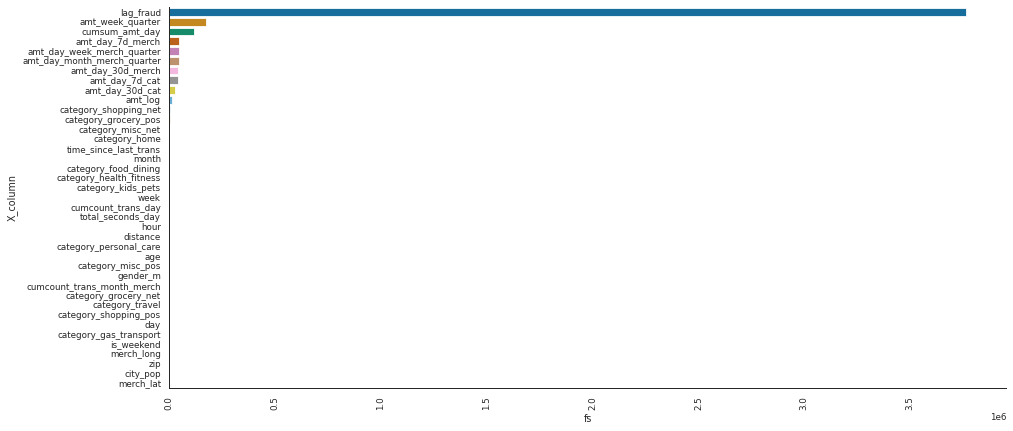

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# instantiate K-Best Selection using F Classification
fs = SelectKBest(score_func=f_classif, k=20)

# learn relationship from training data
fs.fit(X_train_df, y_train_df)

# transform train input data
X_train_fs = fs.transform(X_train_df)

# ticks names and order
fs_scores = pd.DataFrame({"X_column": X_train_df.columns, 
                          "fs": fs.scores_}).sort_values(by="fs", 
                                                         ascending=False)
# plot
fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(y=fs_scores["X_column"], x=fs_scores["fs"], palette="colorblind", 
            orient="h")
plt.xticks(rotation=90)
sns.despine()
plt.show()

## Random Forest: Feature importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# create RandomForestClassifier object
model_RFC = RandomForestClassifier(max_depth=10)

# fit the model
model_RFC.fit(X_train_df, y_train_df)

# model predictions
train_preds = model_RFC.predict(X_train_df)

# AUC score in the train dataset
print('AUC on train data: ', roc_auc_score(y_train_df, train_preds))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


AUC on train data:  0.9817491585404836


AttributeError: ignored

<Figure size 720x504 with 0 Axes>

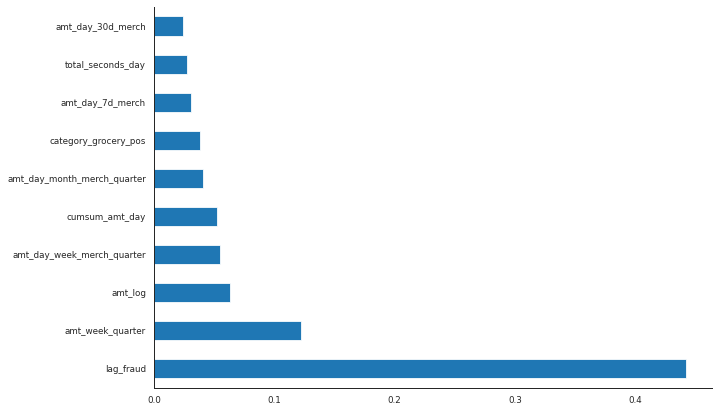

In [ ]:
# plot the 10 most important features
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFC.feature_importances_, 
                             index=X_train_df.columns)
feat_importances.sort_values(ascending=True).nlargest(10).plot(kind='barh')
sns.despine()

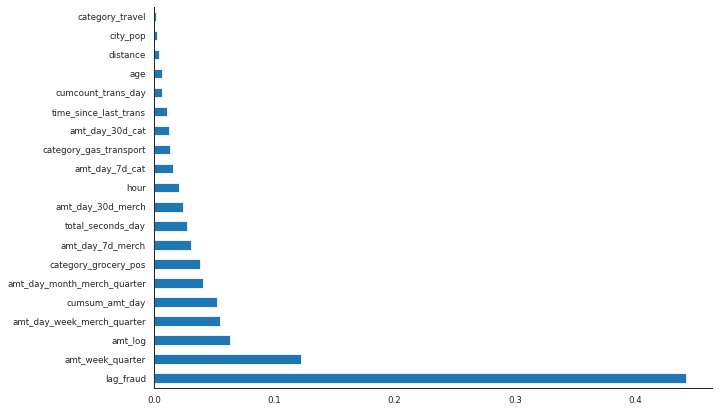

In [ ]:
# plot the 20 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFC.feature_importances_, index=X_train_df.columns)
feat_importances.sort_values(ascending=False).nlargest(20).plot(kind='barh')
sns.despine()

# Conclusion